In [1]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score


# NN packages
import os
import time

import scipy as sci
import scipy.io as sio

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras


from numpy.random import seed
seed(100)

from IPython.display import clear_output

In [2]:
# train = pd.read_excel('lendingclub_traindata.xlsx')
# validation=pd.read_excel('lendingclub_valdata.xlsx')
# test = pd.read_excel('lendingclub_testdata.xlsx')

df = pd.read_excel("lending_clubFull_Data_Set.xlsx")
df = df.iloc[:, 1:] # Remove index column
print(df.columns.tolist())

df.head(2)

['id', 'member_id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_las

,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,263591,545710,20000.0,60 months,17.93,342.94,E,E5,Wylie ISD,1 year,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
1,1613916,69664096,30000.0,36 months,11.99,996.29,C,C1,Sergeant,10+ years,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN


## Quick Fixes
- Nan vales set to 0
- Sample of DF to reduce computational load

In [3]:
#
df = df.replace(np.nan, 0)
# DF is too large for my computer
df = df.sample(frac= .5, random_state=100)

## Data Pre-processing

In [4]:
# Verify categorical values
def get_cat_fields(df):
    return df.select_dtypes(exclude = ['int64', 'float64']).columns.tolist()


print('The categorical features are: ' + str(get_cat_fields(df)))

The categorical features are: ['member_id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'next_pymnt_d', 'last_credit_pull_d', 'application_type', 'verification_status_joint', 'sec_app_earliest_cr_line', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date']


In [5]:
# In hindsight, dates cause issues, we can do some binning in the future but for now we just remove.
current_cols, final_cols = df.columns.tolist(), []

for i in current_cols:
    if "date" not in i and df[i].dtype != '<M8[ns]':
        final_cols.append(i)
print("There are " + str(len(current_cols) - len(final_cols)) + " date columns")


df = df[final_cols]

There are 5 date columns


In [6]:
df.shape # Double check that date cols removed

#hi

(12500, 129)

In [7]:
df["loan_status"].value_counts()

Current                                                5987
Fully Paid                                             4883
Charged Off                                            1301
Late (31-120 days)                                      173
In Grace Period                                          85
Late (16-30 days)                                        53
Does not meet the credit policy. Status:Fully Paid       15
Does not meet the credit policy. Status:Charged Off       3
Name: loan_status, dtype: int64

In [8]:
df["loan_status"] = df["loan_status"].apply(lambda x: 1 if (x == 'Fully Paid') or (x == 'Current') else 0)

# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.8

X = df.drop(columns = ['loan_status']).copy()
X = pd.get_dummies(df, drop_first=True)
y = df['loan_status']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(10000, 23456)
(10000,)
(1250, 23456)
(1250,)
(1250, 23456)
(1250,)


(None, None)

In [9]:
X_train.shape

(10000, 23456)

In [10]:
y_test.head(2)

13495    1
8600     0
Name: loan_status, dtype: int64

In [11]:
# Scale data using the mean and standard deviation of the training set. 
# This is not necessary for the simple logistic regression we will do here 
# but should be done if L1 or L2 regrularization is carried out
# X_test=(X_test-X_train.mean())/X_train.std()
# X_valild=(X_valid-X_train.mean())/X_train.std()
# X_train=(X_train-X_train.mean())/X_train.std()

In [12]:
freq = y_train.value_counts()           # count frequency of different classes in training swet
freq/sum(freq)*100                      # get percentage of above

1    87.0
0    13.0
Name: loan_status, dtype: float64

In [13]:
all = [X_train, y_train, X_valid, y_valid, X_test, y_test]
for dataset in all:
    dataset.replace(np.nan, 0)

In [14]:
#Create an ionstance of logisticregression named lgstc_reg 

lgstc_reg =  LogisticRegression(penalty="none",solver="newton-cg")     

# Fit logististic regression to training set

lgstc_reg.fit(X_train, y_train)                                        # fit training data on logistic regression 


print(lgstc_reg.intercept_, lgstc_reg.coef_)                           # get the coefficients of each features

[-0.00120053] [[ 1.47284450e-07 -4.13166737e-05 -4.65181996e-02 ... -3.81134886e-07
   1.80405105e-07 -2.46411359e-05]]


When used on scaled data the model has a bias of 1.416 and coefficients of 0.145, 0.034, -0.324 and 0.363. We now test the model on the validation set.

In [15]:
# y_train_pred, y_val_pred, and y_test_pred are the predicted probabilities for the training set
# validation set and test set using the fitted logistic regression model

y_train_pred=lgstc_reg.predict_proba(X_train)
y_val_pred=lgstc_reg.predict_proba(X_valid)
y_test_pred=lgstc_reg.predict_proba(X_test)

# Calculate maximum likelihood for training set, validation set, and test set

mle_vector_train = np.log(np.where(y_train == 1, y_train_pred[:,1], y_train_pred[:,0]))
mle_vector_val = np.log(np.where(y_valid == 1, y_val_pred[:,1], y_val_pred[:,0]))
mle_vector_test = np.log(np.where(y_test == 1, y_test_pred[:,1], y_test_pred[:,0]))

# Calculate cost functions from maximum likelihoods

cost_function_training=np.negative(np.sum(mle_vector_train)/len(y_train))
cost_function_val=np.negative(np.sum(mle_vector_val)/len(y_valid))
cost_function_test=np.negative(np.sum(mle_vector_test)/len(y_test))

print('cost function training set =', cost_function_training)
print('cost function validation set =', cost_function_val)
print('cost function test set =', cost_function_test)



cost function training set = 0.18619086655754405
cost function validation set = 0.1911489980067489
cost function test set = 0.1883121594080268


<br> 
An analyst must decide on a criterion for predicting whether loan will be good or default. This involves specifying a threshold By default this threshold is set to 0.5, i.e., loans are separated into good and bad categories according to whether the probability of no default is greater or less than 0.5. However this does not work well for an imbalanced data set such as this. It would predict that all loans are good! We will look at the results for few other thresholds. 



In [16]:
THRESHOLD = [.75, .80, .85]
# Create dataframe to store resultd
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true pos rate", "true neg rate", "false pos rate", "precision", "f-score"]) # df to store results

# Create threshold row
results['THRESHOLD'] = THRESHOLD                                                                         
             
j = 0                                                                                                      

# Iterate over the 3 thresholds

for i in THRESHOLD:                                                                                       
    
    
    #lgstc_reg.fit(X_train, y_train)                                                                    
    
    
    # If prob for test set > threshold predict 1
    preds = np.where(lgstc_reg.predict_proba(X_test)[:,1] > i, 1, 0)                                      
    
    
    # create confusion matrix 
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None) / len(y_test))*100                   # confusion matrix (in percentage)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
   
    j += 1

print('ALL METRICS')
print( results.T)

    
    
   

Confusion matrix for threshold = 0.75
[[82.    4.08]
 [ 3.44 10.48]]
 
Confusion matrix for threshold = 0.8
[[81.04  5.04]
 [ 2.8  11.12]]
 
Confusion matrix for threshold = 0.85
[[79.2   6.88]
 [ 2.48 11.44]]
 
ALL METRICS
                       0         1         2
THRESHOLD           0.75       0.8      0.85
accuracy          0.9248    0.9216    0.9064
true pos rate   0.952602   0.94145  0.920074
true neg rate   0.752874  0.798851  0.821839
false pos rate  0.247126  0.201149  0.178161
precision       0.959738  0.966603  0.969638
f-score         0.956157  0.953861  0.944206


<br>
This table shows that there is a trade off betwee the true positive rate and the false positive rate.  
We can improve the percentage of good loans we identify only by increasing the percentage of bad that are misclassified.
The receiver operating curve (ROC) captures this trade off by considering different thresholds.

AUC random predictions = 0.5
AUC predictions from logistic regression model = 0.9460539247105072


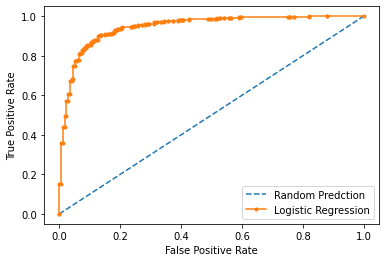

In [17]:

# Calculate the receiver operating curve and the AUC measure

lr_prob=lgstc_reg.predict_proba(X_test)
lr_prob=lr_prob[:, 1]
ns_prob=[0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test, ns_prob)
lr_auc=roc_auc_score(y_test,lr_prob)
print("AUC random predictions =", ns_auc)
print("AUC predictions from logistic regression model =", lr_auc)
ns_fpr,ns_tpr,_=roc_curve(y_test,ns_prob)
lr_fpr,lr_tpr,_=roc_curve(y_test,lr_prob)

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Predction')
plt.plot(lr_fpr,lr_tpr,marker='.',label='Logistic Regression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Neural network setup

In [18]:
X_train.shape

(10000, 23456)

In [19]:
# Scale features based on Z-Score
scaler = StandardScaler()
scaler.fit(X_train)


X_scaled_train = scaler.transform(X_train)
X_scaled_vals = scaler.transform(X_valid)
X_scaled_test = scaler.transform(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_valid)
y_test = np.asarray(y_test)

In [87]:
X_scaled_test

array([[ 1.17275848, -0.30138524,  0.0969726 , ..., -0.06944891,
        -0.02646678, -0.0548546 ],
       [-1.21467054, -0.30138524, -1.4029623 , ..., 14.39907404,
        -0.02646678, -0.0548546 ],
       [ 0.07228798, -0.71374941,  0.42674552, ..., -0.06944891,
        -0.02646678, -0.0548546 ],
       ...,
       [-1.18353311, -0.87411326, -1.00510723, ..., -0.06944891,
        -0.02646678, -0.0548546 ],
       [ 0.4038174 , -0.07229403, -0.38811273, ..., -0.06944891,
        -0.02646678, -0.0548546 ],
       [ 0.77979563,  2.33316367,  2.47559277, ..., -0.06944891,
        -0.02646678, -0.0548546 ]])

In [21]:
# Base model
model = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (23456,)),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                Dense(1)])

# Changing the number of hidden layers
two_layers = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (23456,)),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                Dense(1)])

three_layers = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (23456,)),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                Dense(1)])

# Changing the number of neurons
fewer_neurons = keras.models.Sequential([Dense(10,activation = "sigmoid",input_shape = (23456,)),
                                 Dense(10,activation = "sigmoid"),Dense(10,activation = "sigmoid"),
                                Dense(1)])

more_neurons = keras.models.Sequential([Dense(10,activation = "sigmoid",input_shape = (23456,)),
                                 Dense(10,activation = "sigmoid"),Dense(10,activation = "sigmoid"),
                                Dense(1)])

# List for all the models
# models = [model]
models = [model, two_layers, three_layers, fewer_neurons, more_neurons]


# Complie function allows you to choose your measure of loss and optimzer
for mdl in models:
    mdl.compile(loss = "mae",optimizer = "Adam")


In [22]:
# Create checkpoints and early stop files for each model
checkpoints, early_stops = [], []
for n, mdl in enumerate(models, 1):
    checkpoints.append(keras.callbacks.ModelCheckpoint("Model " + str(n) + ".h5",save_best_only = True))
    early_stops.append(keras.callbacks.EarlyStopping(patience = 5000,restore_best_weights = True))
    


In [25]:
print(len(models))

5


In [27]:
# Training with callback

history_ = []
for ind, mdl in enumerate(models, 0): 
    history_.append(mdl.fit(X_scaled_train,y_train,epochs= 100,verbose = 0, validation_data=(X_scaled_vals,y_val),
                callbacks=[checkpoints[ind],early_stops[ind]]))



## Last update here ==================================================

To do:
- complete nn